In [ ]:
# if you try similar methods
# as ExU but applied to standard
# Dense unit then it doesn't work
# anywhere near as well as the ExU.
# 
# Fundamentally ExU operations are different
# to the Dense operations
# In particular it works on single features
# at a time and instead of matrix multiplations
# it uses row-wise broadcasting.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import tensorflow as tf

In [4]:
def exu(x, weight, bias):
    """ExU hidden unit modification."""
    return tf.exp(weight) * (x - bias)


# Activation Functions
def relu(x, weight, bias):
    """ReLU activation."""
    return tf.nn.relu(weight * (x - bias))


def relu_n(x, n=1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)

In [309]:
class ActivationLayer(tf.keras.layers.Layer):
    """Custom activation Layer to support ExU hidden units."""

    def __init__(self,
               num_units,
               name = None,
               activation = 'exu',
               trainable = True):
        """Initializes ActivationLayer hyperparameters.
        Args:
          num_units: Number of hidden units in the layer.
          name: The name of the layer.
          activation: Activation to use. The default value of `None` corresponds to
            using the ReLU-1 activation with ExU units while `relu` would use
            standard hidden units with ReLU activation.
          trainable: Whether the layer parameters are trainable or not.
        """
        super(ActivationLayer, self).__init__(trainable=trainable, name=name)
        self.num_units = num_units
        self._trainable = trainable
        if activation == 'relu':
            self._activation = relu
            self._beta_initializer = 'glorot_uniform'
        elif activation == 'exu':
            self._activation = lambda x, weight, bias: relu_n(exu(x, weight, bias))
            #       self._beta_initializer = tf.initializers.truncated_normal(
            #           mean=4.0, stddev=0.5)\
            self._beta_initializer = tf.initializers.TruncatedNormal(
            mean=4.0, stddev=0.5)
        else:
            raise ValueError('{} is not a valid activation'.format(activation))

    def build(self, input_shape):
        """Builds the layer weight and bias parameters."""
        self._beta = self.add_weight(
            name='beta',
            shape=[input_shape[-1], self.num_units],
            initializer=self._beta_initializer,
            trainable=self._trainable)
        self._c = self.add_weight(
            name='c',
            shape=[1, self.num_units],
        #         initializer=tf.initializers.truncated_normal(stddev=0.5),
            initializer=tf.initializers.TruncatedNormal(stddev=0.5),
            trainable=self._trainable)
        super(ActivationLayer, self).build(input_shape)

    @tf.function
    def call(self, x):
        """Computes the output activations."""
        center = tf.tile(self._c, [tf.shape(x)[0], 1])

        out = self._activation(x, self._beta, center)
        return out

In [310]:
class ExpDense(tf.keras.layers.Layer):
    def __init__(self, units):
        super(ExpDense, self).__init__()
        self.units = units
        self._activation = lambda z: relu_n(z)

    def build(self, input_shape):
        self.w = self.add_weight(
            name='weight',
            shape=(input_shape[-1], self.units),
            initializer=tf.initializers.TruncatedNormal(
            mean=4.0, stddev=5.5), trainable=True
        )
        self.b = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer=tf.initializers.TruncatedNormal(stddev=0.5), trainable=True)
        
    def call(self, inputs):
        z = tf.matmul(inputs, tf.math.exp(self.w)) + self.b
        h = self._activation(z)
        return h


In [375]:
input_dim = 1
output_dim = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(input_dim,)))
model.add(ActivationLayer(500))
# model.add(ActivationLayer(500, activation='relu'))
# model.add(ExpDense(500))
# model.add(tf.keras.layers.Dense(500, activation='relu'))
# model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(output_dim, activation='linear'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_layer_13 (Activat (None, 500)               1000      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 501       
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


In [376]:
def gen_test_data():
    # x = np.linspace(-np.pi/2., np.pi/2., 100)
    # y = np.cos(10*x) + np.sin(5*x)
    x = np.linspace(0, 1, 200)
    y = np.cos(50*x) + np.sin(5*x)
    return x, y

In [377]:
x, y = gen_test_data()

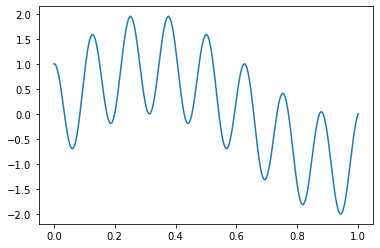

In [378]:
plt.figure()
plt.plot(x, y)

In [379]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
model.compile(loss='mse', optimizer=opt)

In [380]:
%%time
history = model.fit(x, y, epochs=1000, batch_size=x.shape[0])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 2.3571
Epoch 2/1000
1/1 [==============================] - 0s 833us/step - loss: 11.3701
Epoch 3/1000
1/1 [==============================] - 0s 874us/step - loss: 1.9959
Epoch 4/1000
1/1 [==============================] - 0s 990us/step - loss: 2.5954
Epoch 5/1000
1/1 [==============================] - 0s 877us/step - loss: 5.7725
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 3.5266
Epoch 7/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.6550
Epoch 8/1000
1/1 [==============================] - 0s 924us/step - loss: 0.9916
Epoch 9/1000
1/1 [==============================] - 0s 940us/step - loss: 2.8564
Epoch 10/1000
1/1 [==============================] - 0s 873us/step - loss: 2.9199
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 1.3531
Epoch 12/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.3469
Epoch 13/1000
1/1 [===============

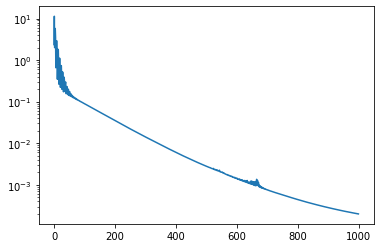

In [381]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

In [382]:
x.shape

(200,)

In [383]:
xnew = np.linspace(0,1,1000)

In [384]:
yhat = model.predict(x)
# yhat2 = model.predict(xnew)

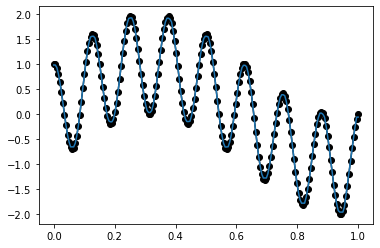

In [385]:
plt.figure()
plt.plot(x, y, 'k-o')
plt.plot(x, yhat)
# plt.plot(xnew, yhat2)

In [386]:
X = tf.convert_to_tensor( np.random.random(size=(5,2)) )
W = tf.convert_to_tensor( np.random.random(size=(2,6)) )
# B = tf.convert_to_tensor( np.ones(shape=(1,6)) ) # this also works i think
B = tf.convert_to_tensor( np.ones(shape=(6,)) )

In [201]:
X

<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
array([[0.56403097, 0.80586314],
       [0.58476993, 0.87123246],
       [0.8237568 , 0.12659399],
       [0.18387494, 0.37625214],
       [0.88445225, 0.28861284]])>

In [202]:
W

<tf.Tensor: shape=(2, 6), dtype=float64, numpy=
array([[0.7387902 , 0.98745737, 0.90836493, 0.53501095, 0.21360079,
        0.90443104],
       [0.32334082, 0.00379875, 0.92758788, 0.76757661, 0.83166943,
        0.89119305]])>

In [203]:
B

<tf.Tensor: shape=(6,), dtype=float64, numpy=array([1., 1., 1., 1., 1., 1.])>

In [204]:
tf.matmul(X,W)

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[0.67726901, 0.56001782, 1.25985483, 0.92032444, 0.7906892 ,
        1.22830675],
       [0.71372732, 0.58074498, 1.33932917, 0.98159597, 0.84948472,
        1.30532039],
       [0.64951646, 0.81390562, 0.86569883, 0.53788949, 0.28123945,
        0.8578509 ],
       [0.25750268, 0.18299796, 0.51603247, 0.38717745, 0.35219323,
        0.5016155 ],
       [0.74674497, 0.87445526, 1.07111918, 0.6947241 , 0.42895018,
        1.05713583]])>

In [205]:
tf.matmul(X,W) + B

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[1.67726901, 1.56001782, 2.25985483, 1.92032444, 1.7906892 ,
        2.22830675],
       [1.71372732, 1.58074498, 2.33932917, 1.98159597, 1.84948472,
        2.30532039],
       [1.64951646, 1.81390562, 1.86569883, 1.53788949, 1.28123945,
        1.8578509 ],
       [1.25750268, 1.18299796, 1.51603247, 1.38717745, 1.35219323,
        1.5016155 ],
       [1.74674497, 1.87445526, 2.07111918, 1.6947241 , 1.42895018,
        2.05713583]])>

In [241]:
Bprime = tf.convert_to_tensor( np.ones(shape=(1,6)) )
# Bprime = tf.convert_to_tensor( np.ones(shape=(6,)) )

In [275]:
# B2 = np.row_stack((B.numpy(),B.numpy(),B.numpy(),B.numpy(),B.numpy()))
B2 = np.row_stack((Bprime.numpy(),Bprime.numpy(),Bprime.numpy(),Bprime.numpy(),Bprime.numpy()))

In [276]:
B2.shape

(5, 6)

In [244]:
Bc = tf.tile(Bprime, [tf.shape(X)[0], 1])

In [245]:
Bc

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])>

In [246]:
X-Bc

InvalidArgumentError: Incompatible shapes: [5,2] vs. [5,6] [Op:Sub]

In [247]:
X[:,0][:,tf.newaxis].shape

TensorShape([5, 1])

In [248]:
X

<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
array([[0.56403097, 0.80586314],
       [0.58476993, 0.87123246],
       [0.8237568 , 0.12659399],
       [0.18387494, 0.37625214],
       [0.88445225, 0.28861284]])>

In [249]:
X[:,0][:,tf.newaxis]-Bc

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[-0.43596903, -0.43596903, -0.43596903, -0.43596903, -0.43596903,
        -0.43596903],
       [-0.41523007, -0.41523007, -0.41523007, -0.41523007, -0.41523007,
        -0.41523007],
       [-0.1762432 , -0.1762432 , -0.1762432 , -0.1762432 , -0.1762432 ,
        -0.1762432 ],
       [-0.81612506, -0.81612506, -0.81612506, -0.81612506, -0.81612506,
        -0.81612506],
       [-0.11554775, -0.11554775, -0.11554775, -0.11554775, -0.11554775,
        -0.11554775]])>

In [250]:
X[:,1][:,tf.newaxis]-Bc

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[-0.19413686, -0.19413686, -0.19413686, -0.19413686, -0.19413686,
        -0.19413686],
       [-0.12876754, -0.12876754, -0.12876754, -0.12876754, -0.12876754,
        -0.12876754],
       [-0.87340601, -0.87340601, -0.87340601, -0.87340601, -0.87340601,
        -0.87340601],
       [-0.62374786, -0.62374786, -0.62374786, -0.62374786, -0.62374786,
        -0.62374786],
       [-0.71138716, -0.71138716, -0.71138716, -0.71138716, -0.71138716,
        -0.71138716]])>

In [278]:
X[:,0][:,tf.newaxis]-Bprime

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[-0.43596903, -0.43596903, -0.43596903, -0.43596903, -0.43596903,
        -0.43596903],
       [-0.41523007, -0.41523007, -0.41523007, -0.41523007, -0.41523007,
        -0.41523007],
       [-0.1762432 , -0.1762432 , -0.1762432 , -0.1762432 , -0.1762432 ,
        -0.1762432 ],
       [-0.81612506, -0.81612506, -0.81612506, -0.81612506, -0.81612506,
        -0.81612506],
       [-0.11554775, -0.11554775, -0.11554775, -0.11554775, -0.11554775,
        -0.11554775]])>

In [277]:
X[:,1][:,tf.newaxis]-Bprime

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[-0.19413686, -0.19413686, -0.19413686, -0.19413686, -0.19413686,
        -0.19413686],
       [-0.12876754, -0.12876754, -0.12876754, -0.12876754, -0.12876754,
        -0.12876754],
       [-0.87340601, -0.87340601, -0.87340601, -0.87340601, -0.87340601,
        -0.87340601],
       [-0.62374786, -0.62374786, -0.62374786, -0.62374786, -0.62374786,
        -0.62374786],
       [-0.71138716, -0.71138716, -0.71138716, -0.71138716, -0.71138716,
        -0.71138716]])>

In [289]:
W.shape

TensorShape([2, 6])

In [290]:
X[:,0][:,tf.newaxis].shape

TensorShape([5, 1])

In [291]:
Bprime.shape

TensorShape([1, 6])

In [298]:
XmB=(X[:,0][:,tf.newaxis]-Bprime)

In [299]:
XmB.shape

TensorShape([5, 6])

In [300]:
W0=W[0,:][tf.newaxis,:]

In [301]:
W0.shape

TensorShape([1, 6])

In [302]:
W0*XmB

<tf.Tensor: shape=(5, 6), dtype=float64, numpy=
array([[-0.32208965, -0.43050083, -0.39601897, -0.2332482 , -0.09312333,
        -0.39430392],
       [-0.30676791, -0.41002199, -0.37718043, -0.22215263, -0.08869347,
        -0.37554696],
       [-0.13020675, -0.17403265, -0.16009314, -0.09429204, -0.03764569,
        -0.15939982],
       [-0.6029452 , -0.8058887 , -0.74133938, -0.43663584, -0.17432496,
        -0.73812883],
       [-0.08536555, -0.11409848, -0.10495953, -0.06181931, -0.02468109,
        -0.10450497]])>

In [305]:
XmB[0]*W0

<tf.Tensor: shape=(1, 6), dtype=float64, numpy=
array([[-0.32208965, -0.43050083, -0.39601897, -0.2332482 , -0.09312333,
        -0.39430392]])>

In [306]:
XmB[1]*W0

<tf.Tensor: shape=(1, 6), dtype=float64, numpy=
array([[-0.30676791, -0.41002199, -0.37718043, -0.22215263, -0.08869347,
        -0.37554696]])>

In [308]:
XmB[4]*W0

<tf.Tensor: shape=(1, 6), dtype=float64, numpy=
array([[-0.08536555, -0.11409848, -0.10495953, -0.06181931, -0.02468109,
        -0.10450497]])>